# 일조량에 따른 토마토 생산량과 가격 예측

- 토마토마(김준회, 연제호, 정다영, 추영은)
- 발표일 : 2020년 3월 19일

# 1. 서론

### 1) 분석 배경

최근 몇년간 미세먼지에 대한 관심이 높아졌다. 미세먼지는 황사처럼 하늘을 부옇게 만들고 먼거리까지 이동한다는 점에서 매우 비슷하나 주로 봄에 영향을 주는 황사와 달리 일년 내내 영향을 주며 발생 과정과 특성 역시 많은 차이가 있다. 미세먼지는 가정의 난방과 취사, 자동차 운행, 공장에서의 화석연료의 사용, 산불 및 화전 경작 등으로 발생한 인위적인 입자로 크기는 황사보다 훨씬 작은 2㎛(마이크로미터) 이하이다. 지름 10㎛ 이하의 먼지는 체내에 흡수되어 다양한 질병의 원인이 된다는 내용이 널리 알려져 마스크가 생활화되었다. 

미세먼지는 인체 뿐만 아니라 농가에도 피해를 주고 있다. 비닐하우스에서 재배하는 식물의 경우 농가에서 비닐하우스 위에 내려앉은 미세먼지를 자주 걷어내기 어렵고 유리온실도 마찬가지로 미세먼지으로 인한 투광량이 떨어져 작물의 상품성과 생산성이 떨어진다는 것이다. 특히, 토마토의 경우 노지보다는 하우스 시설에서 재배하고 있고 저장성이 약한데다가 국내 생산 의존도가 높아 어느 농산물 보다 가격 변동이 크다고 한다.

### 2) 분석 목적

미세먼지에 따른 일조량의 변화와 토마토 생산량 및 가격을 예측하고자 한다.

## 2. 데이터 준비

### 1) 활용 데이터

 데이터 | 사용 변수 | 시점 | 출처 | 파일 형식
:---:|:-------:|:---:|:---:|:--------:
토마토 일별 품목별 도.소매가격정보 | 품목명, 품종명,	시군구,	마켓명,	연도,	날짜,	가격 | 일 | [농산물유통정보](https://kdx.kr/kamis/periodProductList) | csv
농작물생산조사:채소생산량(과채류) | 품종명, 시군구, 마켓명, 연도, 날짜, 가격 | 연 | [통계청](http://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_1ET0027&vw_cd=MT_ZTITLE&list_id=F1H&seqNo=&lang_mode=ko&language=kor&obj_var_id=&itm_id=&conn_path=MT_ZTITLE) | csv
대기오염 최종확정자료  | 지역, 측정소코드, 측정소명, 측정일시, SO2, CO, O3, NO2, PM10 | 시간 | [AirKorea](https://www.airkorea.or.kr/web/last_amb_hour_data?pMENU_NO=123) | xlsx
종관기상관측(ASOS) | 지점명,	일시,	합계 일조시간 | 일 | [기상청 기상자료개방포털](https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36) | csv

#### 종관기상관측(ASOS) 변수 설명

 - 합계 일조시간 : 태양 광선이 구름이나 안개로 가려지지 않고 땅 위를 비친 시간

#### 대기오염 최종확정자료

 - SO2 : 아황산가스
 - CO : 이산화탄소
 - O3 : 오존
 - NO2 : 이산화질소
 - PM10 : 미세먼지

## 3. 데이터 가공

#### 필요한 라이브러리 불러오기

In [2]:
import pandas as pd # 데이터 프레임
import numpy as np # 계산
import re # 정규표현식

import warnings
warnings.filterwarnings('ignore') # warning 메시지 제거

import seaborn as sns # 시각화
import graphviz # 시각화

#### 시각화를 위한 한글 폰트 설정하기

In [3]:
import matplotlib.pyplot as plt

# 한글 폰트 지정
# plt.rc('font', family='AppleGothic') # 맥
plt.rc('font', family='Malgun Gothic') # 윈도우

# 마이너스 값 깨지는 현상 해결
plt.rc('axes', unicode_minus=False)

# 레티나 디스플레이 설정
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('retina')

#### 작업 경로 지정

In [4]:
import os # wd 변경

# os로 작업 경로 지정
os.chdir('/Users/chuu/Documents/GitHub/Learning_Spoons_Second_Project/data')

### 1) 토마토 도매 가격 정보 전처리

In [5]:
# 토마토 일별 도.소매 가격정보 2013-2016년 데이터 불러오기 
tom36 = pd.read_csv('20132016토마토_일별 품목별 도.소매가격정보.csv')

# 데이터 하단에 있는 평균과 평년 데이터 제외
tomp36 = tom36[(tom36['시군구']!='평균') & (tom36['시군구']!='평년')]

# 데이터 확인
tomp36.head()

,품목명,품종명,시군구,마켓명,연도,날짜,가격
0,토마토,토마토(10kg),서울,가락도매,2013,01/02,"29,000"
1,토마토,토마토(10kg),서울,가락도매,2013,01/03,"30,000"
2,토마토,토마토(10kg),서울,가락도매,2013,01/04,"30,000"
3,토마토,토마토(10kg),서울,가락도매,2013,01/07,"30,000"
4,토마토,토마토(10kg),서울,가락도매,2013,01/08,"27,000"


In [6]:
# 토마토 일별 도.소매 가격정보 2017-2019년 데이터 불러오기 
tom78 = pd.read_csv('20172019토마토_일별 품목별 도.소매가격정보.csv')

# 13-16년 데이터와 마찬가지로 평균 평년 데이터 제외. 2019, 2020년 데이터도 제외.
tomp78 = tom78[(tom78['시군구']!='평균') & (tom78['시군구']!='평년') & (tom78['연도']!= 2019) & (tom78['연도']!= 2020)]

# 데이터 확인
tomp78.head()

,품목명,품종명,시군구,마켓명,연도,날짜,가격
0,토마토,토마토(10kg),서울,가락도매,2017,01/02,"43,000"
1,토마토,토마토(10kg),서울,가락도매,2017,01/03,"41,000"
2,토마토,토마토(10kg),서울,가락도매,2017,01/04,"40,000"
3,토마토,토마토(10kg),서울,가락도매,2017,01/05,"38,000"
4,토마토,토마토(10kg),서울,가락도매,2017,01/06,"38,000"


In [7]:
# 데이터 합치기
tomp = pd.concat([tomp36,tomp78])

# 제대로 합쳐졌는지 행 개수 확인
tomp.shape

(7847, 7)

In [8]:
tomp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7847 entries, 0 to 4366
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   품목명     7847 non-null   object
 1   품종명     7847 non-null   object
 2   시군구     7847 non-null   object
 3   마켓명     7847 non-null   object
 4   연도      7847 non-null   int64 
 5   날짜      7847 non-null   object
 6   가격      7847 non-null   object
dtypes: int64(1), object(6)
memory usage: 490.4+ KB


In [9]:
# 품목명이 모두 토마토이고, 품종명 또한 토마토(10kg)으로 같은 정보를 담고 있으므로 품목명 컬럼을 삭제
tomp = tomp.drop('품목명', axis = 1)

# 데이터 확인
tomp.head()

,품종명,시군구,마켓명,연도,날짜,가격
0,토마토(10kg),서울,가락도매,2013,01/02,"29,000"
1,토마토(10kg),서울,가락도매,2013,01/03,"30,000"
2,토마토(10kg),서울,가락도매,2013,01/04,"30,000"
3,토마토(10kg),서울,가락도매,2013,01/07,"30,000"
4,토마토(10kg),서울,가락도매,2013,01/08,"27,000"


In [10]:
# 시군구, 마켓명, 연도, 날짜 오름차순으로 정렬
tomp = tomp.sort_values(by = ['시군구','마켓명', '연도', '날짜'])

# '시군구' 컬럼명을 '도'로 변경
tomp.rename(columns={'시군구':'도'},inplace=True)

# 데이터 확인
tomp.head()

,품종명,도,마켓명,연도,날짜,가격
2955,토마토(10kg),광주,각화도매,2013,01/02,"28,000"
2956,토마토(10kg),광주,각화도매,2013,01/03,"28,000"
2957,토마토(10kg),광주,각화도매,2013,01/04,"28,000"
2958,토마토(10kg),광주,각화도매,2013,01/07,"28,000"
2959,토마토(10kg),광주,각화도매,2013,01/08,"28,000"


In [11]:
# merge함수를 사용하기 위해 일시를 연도와 날짜 컬럼으로 나누기
tomp['월'] = tomp['날짜'].str.split('/').str.get(0)
tomp['일'] = tomp['날짜'].str.split('/').str.get(1) 

# 데이터 확인
tomp.head()

,품종명,도,마켓명,연도,날짜,가격,월,일
2955,토마토(10kg),광주,각화도매,2013,01/02,"28,000",01,02
2956,토마토(10kg),광주,각화도매,2013,01/03,"28,000",01,03
2957,토마토(10kg),광주,각화도매,2013,01/04,"28,000",01,04
2958,토마토(10kg),광주,각화도매,2013,01/07,"28,000",01,07
2959,토마토(10kg),광주,각화도매,2013,01/08,"28,000",01,08


In [12]:
# -을 0으로 변경
tomp['가격'] = tomp['가격'].str.replace('-','0')

# 결측값을 0으로 채우기
tomp['가격'] = tomp['가격'].fillna('0')

# 가격 컬럼의 ,를 제거하고 숫자 타입으로 변환
tomp['가격'] = tomp['가격'].str.replace(',','').astype('int')

# 변경된 컬럼 타입 확인
tomp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7847 entries, 2955 to 486
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   품종명     7847 non-null   object
 1   도       7847 non-null   object
 2   마켓명     7847 non-null   object
 3   연도      7847 non-null   int64 
 4   날짜      7847 non-null   object
 5   가격      7847 non-null   int32 
 6   월       7847 non-null   object
 7   일       7847 non-null   object
dtypes: int32(1), int64(1), object(6)
memory usage: 521.1+ KB


In [13]:
# 도시명을 정식 명칭으로 변경하기 위해 변수 dic에 저장
dic = {'광주':'광주광역시', '대구':'대구광역시', '대전': '대전광역시', '서울':'서울특별시', '부산':'부산광역시'}

In [14]:
# '시군구'컬럼의 값을 dic의 값들로 변경
tomp['도'] = tomp['도'].map(dic)

# 변경된 '시군구' 컬럼 확인
tomp.tail()

,품종명,도,마켓명,연도,날짜,가격,월,일
482,토마토(10kg),서울특별시,가락도매,2018,12/24,30000,12,24
483,토마토(10kg),서울특별시,가락도매,2018,12/26,28000,12,26
484,토마토(10kg),서울특별시,가락도매,2018,12/27,26000,12,27
485,토마토(10kg),서울특별시,가락도매,2018,12/28,26000,12,28
486,토마토(10kg),서울특별시,가락도매,2018,12/31,25000,12,31


In [15]:
# 가격이 없는 서부도매 삭제
tompd = tomp['마켓명'].isin(['서부도매'])
tomp = tomp[~tompd]

In [16]:
# 연월 컬럼 따로 만들고 날짜 형식으로 바꾸기
tomp['연월'] = tomp['연도'].astype('str') + '-' + tomp['월']
tomp.head()

,품종명,도,마켓명,연도,날짜,가격,월,일,연월
2955,토마토(10kg),광주광역시,각화도매,2013,01/02,28000,01,02,2013-01
2956,토마토(10kg),광주광역시,각화도매,2013,01/03,28000,01,03,2013-01
2957,토마토(10kg),광주광역시,각화도매,2013,01/04,28000,01,04,2013-01
2958,토마토(10kg),광주광역시,각화도매,2013,01/07,28000,01,07,2013-01
2959,토마토(10kg),광주광역시,각화도매,2013,01/08,28000,01,08,2013-01


In [21]:
# '일시' 컬럼 따로 만들고 날짜 형식으로 바꾸기
tomp['일시'] = tomp['연도'].astype('str') + '-' + tomp['날짜'].str.split('/').str.get(0)+ '-' +tomp['날짜'].str.split('/').str.get(1)
pd.to_datetime(tomp['일시'])
tomp.head()

,품종명,도,마켓명,연도,날짜,가격,월,일,연월,일시
2955,토마토(10kg),광주광역시,각화도매,2013,01/02,28000,01,02,2013-01,2013-01-02
2956,토마토(10kg),광주광역시,각화도매,2013,01/03,28000,01,03,2013-01,2013-01-03
2957,토마토(10kg),광주광역시,각화도매,2013,01/04,28000,01,04,2013-01,2013-01-04
2958,토마토(10kg),광주광역시,각화도매,2013,01/07,28000,01,07,2013-01,2013-01-07
2959,토마토(10kg),광주광역시,각화도매,2013,01/08,28000,01,08,2013-01,2013-01-08


In [26]:
tomp.to_csv('토마토_도매가격.csv', index=False, encoding = 'cp949')

In [23]:
# 연월 같은 데이터 그룹으로 묶어 가격 평균 내기
tompm = tomp.groupby(['연월'])['가격'].mean().reset_index()

#### 2013년 ~ 2018년 월별 토마토 도매가격

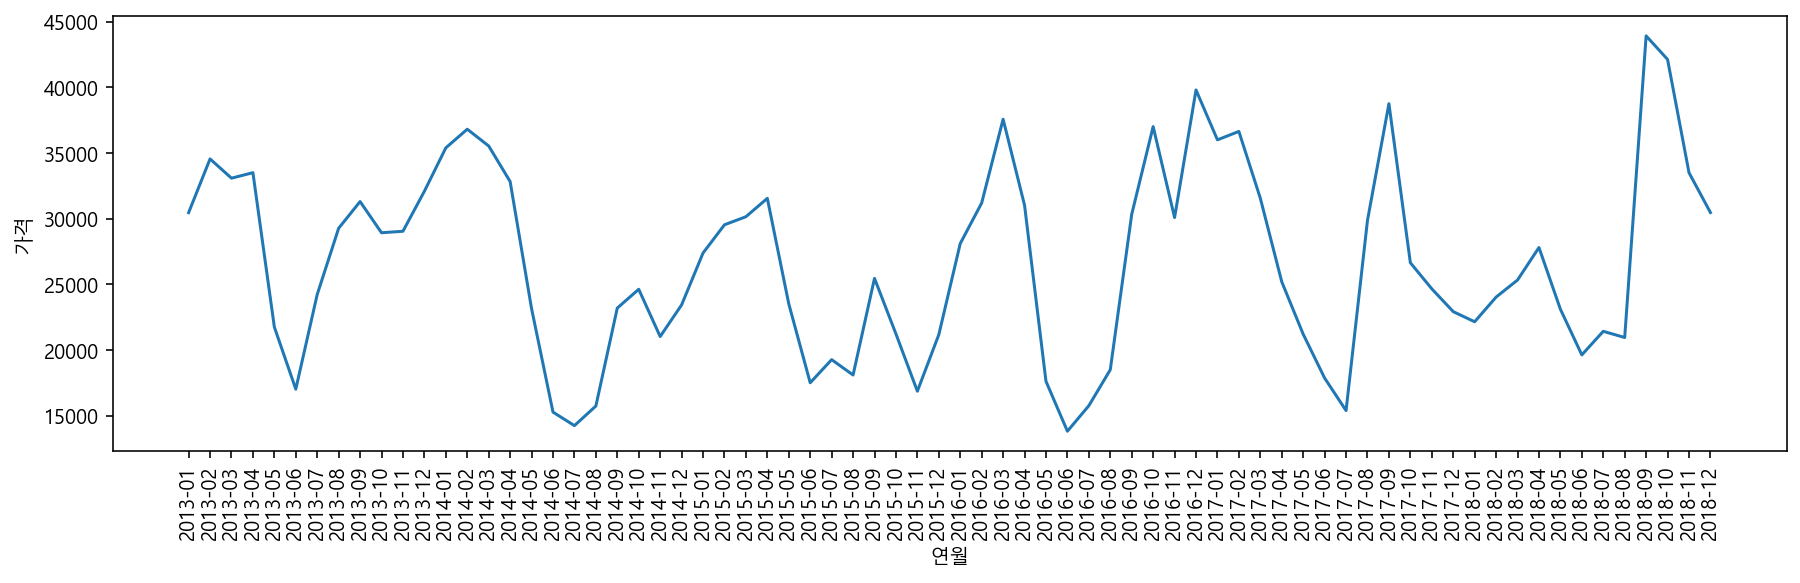

In [24]:
plt.figure(figsize=(15,4))
t = sns.lineplot(data = tompm, x = '연월', y = '가격')
ts = t.set_xticklabels(tompm['연월'],rotation=90)

#### 연도별 토마토 가격

2015년의 토마토 가격이 가장 낮았으며, 2013년의 토마토 가격이 가장 높았다.

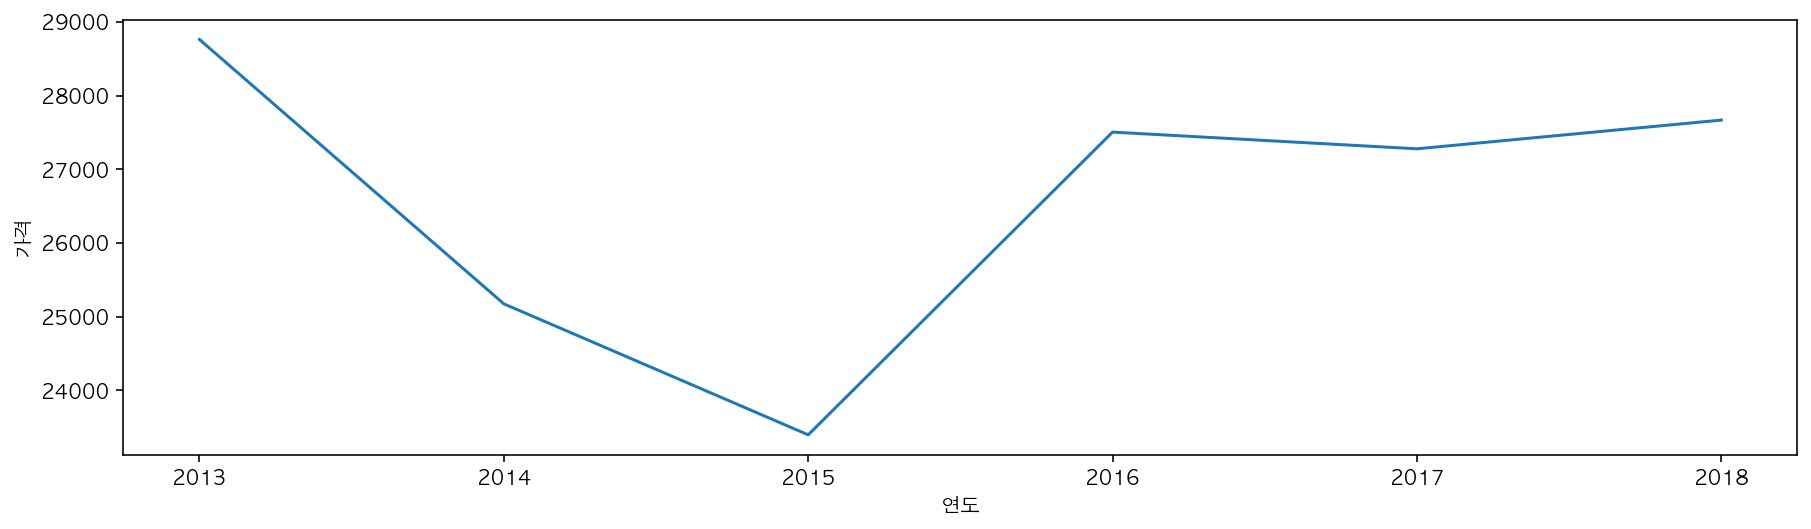

In [20]:
plt.figure(figsize=(15,4))
sns.lineplot(data=tomp, x='연도', y='가격', ci=None)

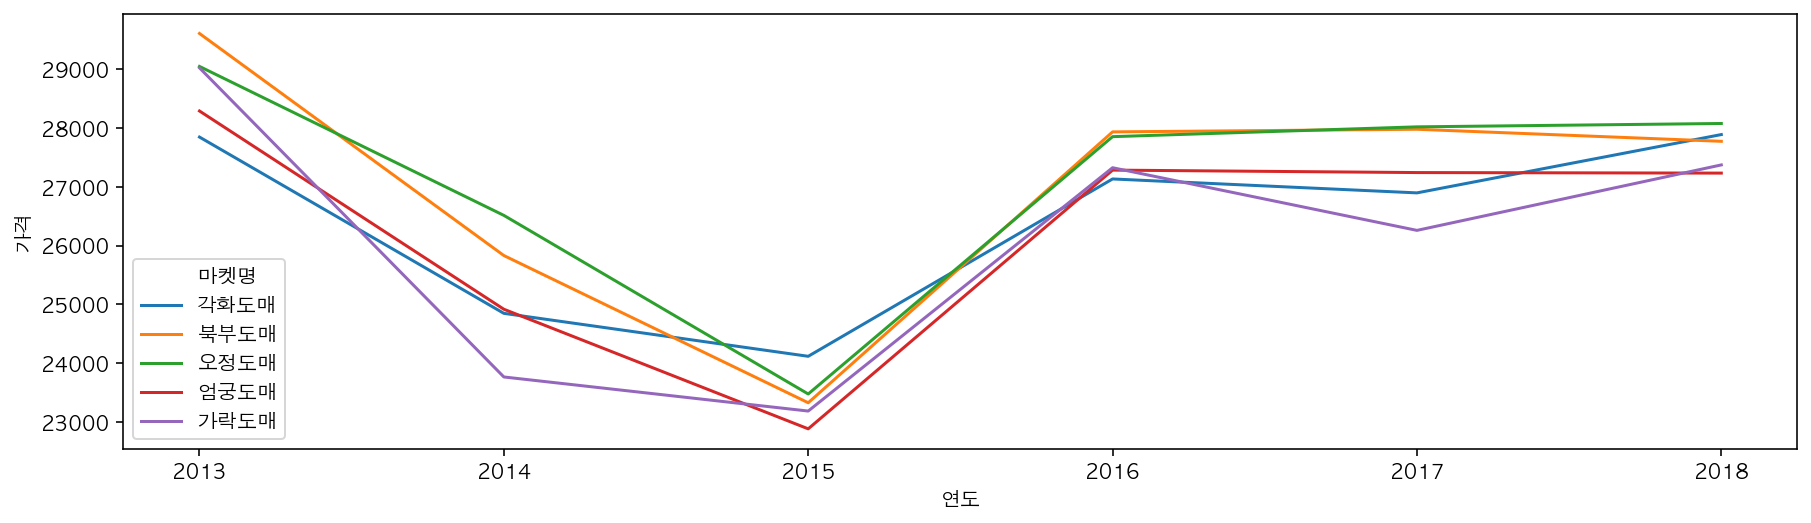

In [21]:
plt.figure(figsize=(15,4))
sns.lineplot(data=tomp, x='연도', y='가격', hue='마켓명', ci=None)

#### 월별 토마토 가격

2-3월은 일조량이 많아 가격이 높았으며 6-7월은 강수가 집중되어 생육이 부진하므로 가격이 낮은 것으로 확인되었다.

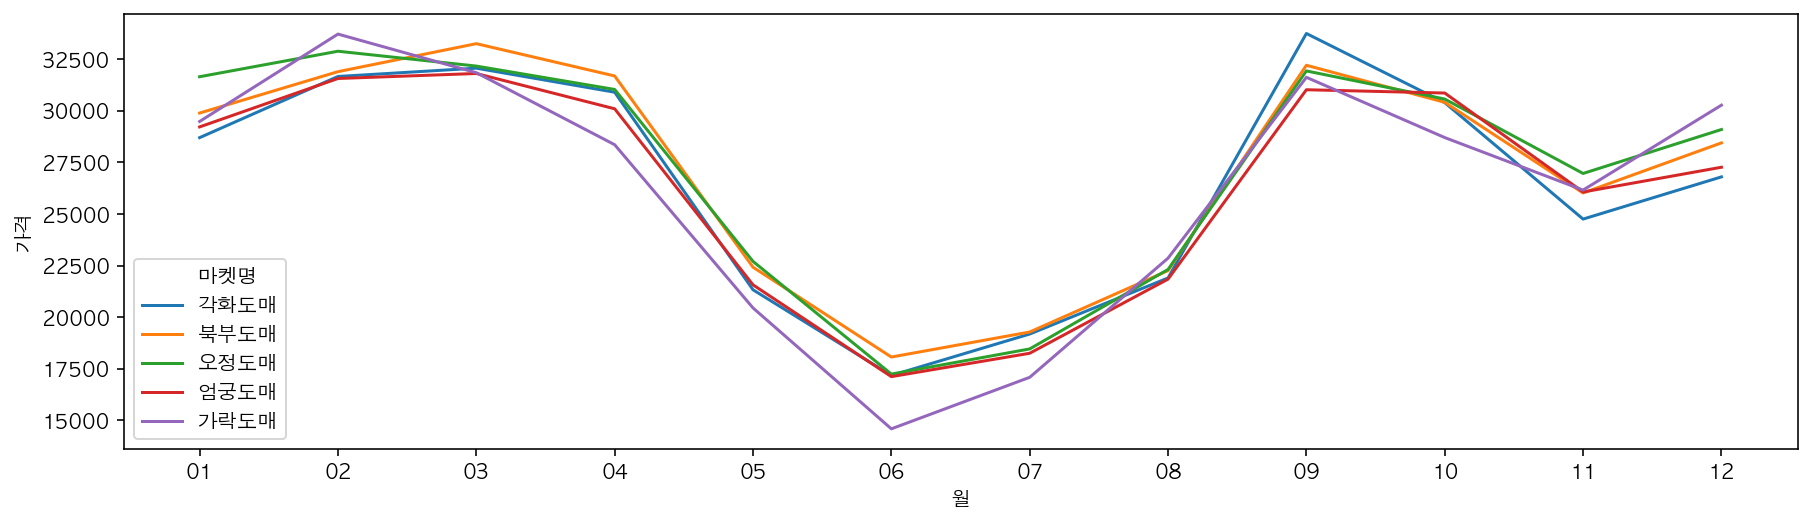

In [22]:
plt.figure(figsize=(15,4))
sns.lineplot(data=tomp, x='월', y='가격', hue='마켓명', ci=None)

### 2) 농작물생산조사:채소생산량(과채류)	

In [23]:
# 토마토 생산량 파일 불러오기
to = pd.read_csv('채소생산량_과채류__20200304201937.csv', encoding='euc-kr')

In [24]:
# 토마토 생산량 파일 확인
to.head()

,시도별,2013,2013.1,2013.2,2013.3,2013.4,2013.5,2013.6,2013.7,2014,...,2017.6,2017.7,2018,2018.1,2018.2,2018.3,2018.4,2018.5,2018.6,2018.7
0,시도별,토마토:면적 (ha),생산량 (톤),노지토마토:면적 (ha),10a당 생산량 (kg),생산량 (톤),시설토마토:면적 (ha),10a당 생산량 (kg),생산량 (톤),토마토:면적 (ha),...,10a당 생산량 (kg),생산량 (톤),토마토:면적 (ha),생산량 (톤),노지토마토:면적 (ha),10a당 생산량 (kg),생산량 (톤),시설토마토:면적 (ha),10a당 생산량 (kg),생산량 (톤)
1,계,6054,388624,0,0,0,6054,6419,388624,7070,...,6142,355107,6058,388657,0,0,0,6058,6415,388657
2,서울특별시,2,137,0,0,0,2,6850,137,1,...,1433,34,4,18,0,0,0,4,450,18
3,부산광역시,355,22056,0,0,0,355,6213,22056,423,...,6081,19196,363,25248,0,0,0,363,6952,25248
4,대구광역시,98,7933,0,0,0,98,8095,7933,71,...,5174,10201,167,11372,0,0,0,167,6800,11372


In [25]:
# 컬럼명의 .1, .2 ...을 수정하기 위해 컬럼명을 리스트에 담기
to_cols = to.columns.to_list()

# for문을 통해 연도의 4글자만 가져오기
for i in range(len(to_cols)):
    if len(to_cols[i]) > 4:
        to_cols[i] = to_cols[i][:4]

In [26]:
# 수정한 연도를 컬럼으로 지정하기
to.columns = to_cols

# 수정한 컬럼명 확인하기
to.head(2)

,시도별,2013,2013,2013,2013,2013,2013,2013,2013,2014,...,2017,2017,2018,2018,2018,2018,2018,2018,2018,2018
0,시도별,토마토:면적 (ha),생산량 (톤),노지토마토:면적 (ha),10a당 생산량 (kg),생산량 (톤),시설토마토:면적 (ha),10a당 생산량 (kg),생산량 (톤),토마토:면적 (ha),...,10a당 생산량 (kg),생산량 (톤),토마토:면적 (ha),생산량 (톤),노지토마토:면적 (ha),10a당 생산량 (kg),생산량 (톤),시설토마토:면적 (ha),10a당 생산량 (kg),생산량 (톤)
1,계,6054,388624,0,0,0,6054,6419,388624,7070,...,6142,355107,6058,388657,0,0,0,6058,6415,388657


In [27]:
# 컬럼을 리스트에 담기
to_cols = to.columns.to_list()

# 첫 번째 행을 to_row에 담기
to_row = to.iloc[0]

# melt를 사용하기 위해 컬럼명 사이에 공백 넣기
to_cols = [f'{i} ' for i in to_cols]
tom = to_cols + to_row

# 리스트 확인하기
tom.head()

시도별                시도별 시도별
2013      2013 토마토:면적 (ha)
2013          2013 생산량 (톤)
2013    2013 노지토마토:면적 (ha)
2013    2013 10a당 생산량 (kg)
Name: 0, dtype: object

In [28]:
# 첫 번째 인덱스명을 '연도'로 수정하기
tom[0] = "연도"

# 첫 번째 컬럼명을 '연도'로 수정하기
to.columns = tom

# 수정한 컬럼명 확인하기
to.head(2)

,연도,2013 토마토:면적 (ha),2013 생산량 (톤),2013 노지토마토:면적 (ha),2013 10a당 생산량 (kg),2013 생산량 (톤),2013 시설토마토:면적 (ha),2013 10a당 생산량 (kg),2013 생산량 (톤),2014 토마토:면적 (ha),...,2017 10a당 생산량 (kg),2017 생산량 (톤),2018 토마토:면적 (ha),2018 생산량 (톤),2018 노지토마토:면적 (ha),2018 10a당 생산량 (kg),2018 생산량 (톤),2018 시설토마토:면적 (ha),2018 10a당 생산량 (kg),2018 생산량 (톤)
0,시도별,토마토:면적 (ha),생산량 (톤),노지토마토:면적 (ha),10a당 생산량 (kg),생산량 (톤),시설토마토:면적 (ha),10a당 생산량 (kg),생산량 (톤),토마토:면적 (ha),...,10a당 생산량 (kg),생산량 (톤),토마토:면적 (ha),생산량 (톤),노지토마토:면적 (ha),10a당 생산량 (kg),생산량 (톤),시설토마토:면적 (ha),10a당 생산량 (kg),생산량 (톤)
1,계,6054,388624,0,0,0,6054,6419,388624,7070,...,6142,355107,6058,388657,0,0,0,6058,6415,388657


In [29]:
# 사용하지 않는 0, 1 행 삭제하기
to = to.drop(labels=[0,1],axis=0)

# 인덱스 리셋하기
to.reset_index(drop=True)

# 수정한 인덱스 확인
to.head()

,연도,2013 토마토:면적 (ha),2013 생산량 (톤),2013 노지토마토:면적 (ha),2013 10a당 생산량 (kg),2013 생산량 (톤),2013 시설토마토:면적 (ha),2013 10a당 생산량 (kg),2013 생산량 (톤),2014 토마토:면적 (ha),...,2017 10a당 생산량 (kg),2017 생산량 (톤),2018 토마토:면적 (ha),2018 생산량 (톤),2018 노지토마토:면적 (ha),2018 10a당 생산량 (kg),2018 생산량 (톤),2018 시설토마토:면적 (ha),2018 10a당 생산량 (kg),2018 생산량 (톤)
2,서울특별시,2,137,0,0,0,2,6850,137,1,...,1433,34,4,18,0,0,0,4,450,18
3,부산광역시,355,22056,0,0,0,355,6213,22056,423,...,6081,19196,363,25248,0,0,0,363,6952,25248
4,대구광역시,98,7933,0,0,0,98,8095,7933,71,...,5174,10201,167,11372,0,0,0,167,6800,11372
5,인천광역시,111,5130,0,0,0,111,4622,5130,120,...,7023,3887,54,3491,0,0,0,54,6515,3491
6,광주광역시,260,5613,0,0,0,260,2159,5613,216,...,7679,9751,123,11753,0,0,0,123,9538,11753


In [30]:
# 롱 포맷으로 변경하기 위해 melt 함수 사용하기
tos = pd.melt(to, id_vars='연도')

# 롱 포맷으로 변경된 데이터 확인
tos.head()

,연도,0,value
0,서울특별시,2013 토마토:면적 (ha),2
1,부산광역시,2013 토마토:면적 (ha),355
2,대구광역시,2013 토마토:면적 (ha),98
3,인천광역시,2013 토마토:면적 (ha),111
4,광주광역시,2013 토마토:면적 (ha),260


In [31]:
# 0과 '연도'를 기준으로 정렬하기
toss = tos.groupby([0,'연도'])['value'].sum()

# 정렬한 데이터를 데이터프레임으로 만들기
toss = pd.DataFrame(toss)

# 데이터프레임 확인하기
toss.head()

value
0                  연도          
2013 10a당 생산량 (kg) 강원도    06245
                   경기도    06606
                   경상남도   07231
                   경상북도   06707
                   광주광역시  02159

In [32]:
# 인덱스 리셋하기
toss = toss.reset_index()

# 컬럼명을 '항목', '시군구'로 변경하기
toss.rename(columns={0:'항목','연도':'도'},inplace=True)

# 변경된 데이터프레임 확인
toss.head()

,항목,도,value
0,2013 10a당 생산량 (kg),강원도,06245
1,2013 10a당 생산량 (kg),경기도,06606
2,2013 10a당 생산량 (kg),경상남도,07231
3,2013 10a당 생산량 (kg),경상북도,06707
4,2013 10a당 생산량 (kg),광주광역시,02159


In [33]:
# '연도' 컬럼 만들기
toss['연도'] = toss['항목'].str[:4]

# '항목' 컬럼에 '연도'를 제외한 내용 남기기
toss['항목']=toss['항목'].str[4:]

# 수정된 내용 확인
toss.head()

,항목,도,value,연도
0,10a당 생산량 (kg),강원도,06245,2013
1,10a당 생산량 (kg),경기도,06606,2013
2,10a당 생산량 (kg),경상남도,07231,2013
3,10a당 생산량 (kg),경상북도,06707,2013
4,10a당 생산량 (kg),광주광역시,02159,2013


In [34]:
toss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 4 columns):
항목       510 non-null object
도        510 non-null object
value    510 non-null object
연도       510 non-null object
dtypes: object(4)
memory usage: 16.1+ KB


In [35]:
# value를 숫자로 변경 시 오류 발생 -> 세종특별자치시에 '-'값이 있기 때문
# '-'를 0으로 변경
toss.loc[toss['도'].str.contains('세종'),'value'] = toss.loc[toss['도'].str.contains('세종'),'value'].str.replace(r'-+','0')

# 'value' 컬럼을 숫자 타입으로 변경
toss['value'] = toss['value'].astype(int)

# 변경된 데이터 확인
toss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 4 columns):
항목       510 non-null object
도        510 non-null object
value    510 non-null int64
연도       510 non-null object
dtypes: int64(1), object(3)
memory usage: 16.1+ KB


In [36]:
# 피벗테이블로 정렬
tt = pd.pivot_table(toss, index= '연도', columns=['항목'], aggfunc='sum')
tt

value                                                          
항목    10a당 생산량 (kg)  노지토마토:면적 (ha)        생산량 (톤)  시설토마토:면적 (ha)  토마토:면적 (ha)
연도                                                                           
2013          97299              0   358919258624           6054         6054
2014          99412              0  1472247968960           7070         7070
2015          98864              0   442608826982           6976         6976
2016          99472              0   380156970303           6391         6391
2017          97133              0   335358529107           5781         5781
2018         101517              0   380223236657           6059         6059

In [37]:
# 컬럼명 확인
tt.columns

MultiIndex([('value', ' 10a당 생산량 (kg)'),
            ('value', ' 노지토마토:면적 (ha)'),
            ('value',       ' 생산량 (톤)'),
            ('value', ' 시설토마토:면적 (ha)'),
            ('value',   ' 토마토:면적 (ha)')],
           names=[None, '항목'])

In [38]:
# 사용하지 않는 노지토마토 면적과 중복되는 토마토면적 컬럼 삭제
tt = tt.drop(labels=[('value', ' 노지토마토:면적 (ha)'),
                    ('value',   ' 토마토:면적 (ha)')], axis=1)

# 컬럼이 삭제되었는지 확인
tt

value                              
항목    10a당 생산량 (kg)        생산량 (톤)  시설토마토:면적 (ha)
연도                                               
2013          97299   358919258624           6054
2014          99412  1472247968960           7070
2015          98864   442608826982           6976
2016          99472   380156970303           6391
2017          97133   335358529107           5781
2018         101517   380223236657           6059

In [39]:
# 인덱스 리셋
tt = tt.reset_index()

# 리셋된 인덱스 확인
tt

연도          value                              
항목        10a당 생산량 (kg)        생산량 (톤)  시설토마토:면적 (ha)
0   2013          97299   358919258624           6054
1   2014          99412  1472247968960           7070
2   2015          98864   442608826982           6976
3   2016          99472   380156970303           6391
4   2017          97133   335358529107           5781
5   2018         101517   380223236657           6059

In [40]:
# 컬럼명 재지정
tt.columns = ['연도', '10a당 생산량 (kg)', '생산량 (톤)','시설토마토:면적 (ha)']

# 지정한 컬럼명 확인
tt

,연도,10a당 생산량 (kg),생산량 (톤),시설토마토:면적 (ha)
0,2013,97299,358919258624,6054
1,2014,99412,1472247968960,7070
2,2015,98864,442608826982,6976
3,2016,99472,380156970303,6391
4,2017,97133,335358529107,5781
5,2018,101517,380223236657,6059


In [41]:
# 10a당 생산량(kg) 증감율 구하기
tabel = []

for i in range(tt.shape[0]):
    if tt['연도'][i] > '2013':
        tr = 1-((tt['10a당 생산량 (kg)'][i-1] / tt['10a당 생산량 (kg)'][i]))
        tabel.append(tr)
        
tabel

[0.02125497927815556,
 -0.005542968117818514,
 0.006112272800386065,
 -0.024080384627263696,
 0.04318488529014841]

In [42]:
# 생산량 (톤) 증감율 구하기
table2 = []

for i in range(tt.shape[0]):
    if tt['연도'][i] > '2013':
        tr = 1-((tt['생산량 (톤)'][i-1] / tt['생산량 (톤)'][i]))
        table2.append(tr)
        
table2

[0.7562100500790356,
 -2.326295995944684,
 -0.1642791308790772,
 -0.13358372400812435,
 0.11799570153696981]

In [43]:
# 시설토마토:면적 (ha) 증감율 구하기
table3 = []

for i in range(tt.shape[0]):
    if tt['연도'][i] > '2013':
        tr = 1-((tt['시설토마토:면적 (ha)'][i-1] / tt['시설토마토:면적 (ha)'][i]))
        table3.append(tr)
        
table3

[0.14370579915134374,
 -0.013474770642201817,
 -0.09153497105304331,
 -0.10551807645736022,
 0.04588215877207458]

#### 시설토마토 면적

시설토마토 면적은 2014년을 기점으로 감소하다가 2018년 상승하였다.

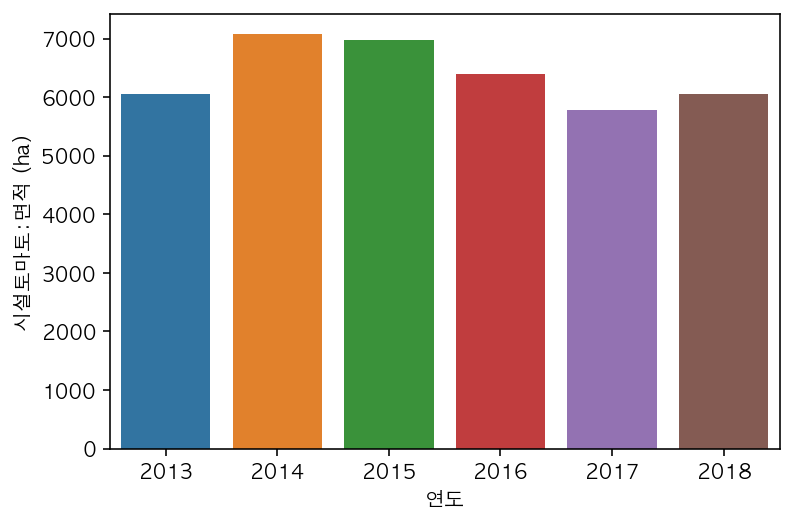

In [44]:
# 시설토마토 면적 그래프
tt1 = sns.barplot(data=tt, x='연도', y='시설토마토:면적 (ha)')

#### 토마토 총 생산량

2014년에 큰 폭으로 증가하였으며, 이후 감소하다가 2018년 소폭 상승하였다.

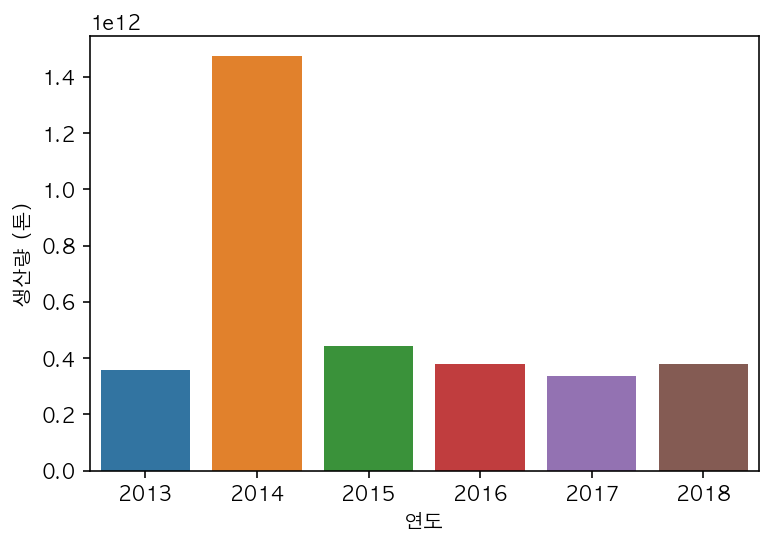

In [45]:
# 시설토마토 면적 그래프
tt2 = sns.barplot(data=tt, x='연도', y='생산량 (톤)')

#### 토마토 재배 면적 당 생산량

 크게 변하지 않았다.

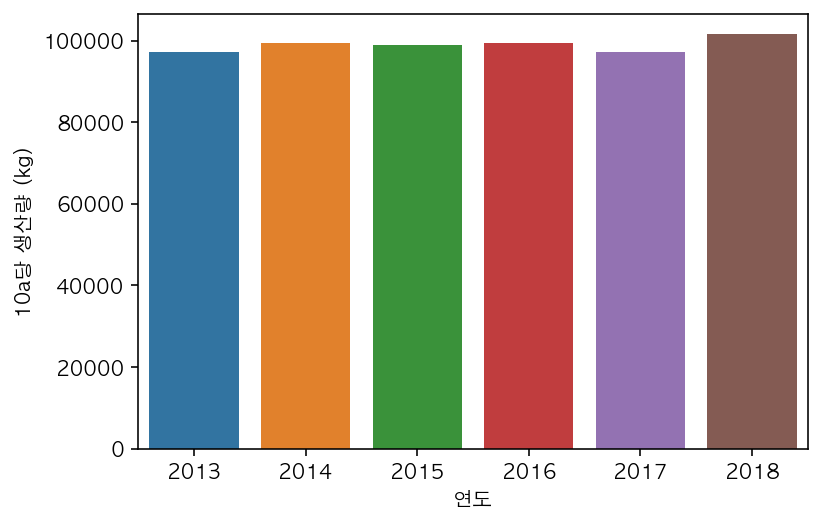

In [46]:
# 면적당 생산량 그래프
tt3 = sns.barplot(data=tt, x='연도', y='10a당 생산량 (kg)')

### 3) 대기오염 최종확정자료

In [111]:
# 빈 리스트 생성하기
list_Data = []

In [112]:
# 컬럼 위치를 변경하기 위해 reColindex 함수 생성

# def reColindex(df, ori, fix):
#     cols = df.columns.tolist()
#     tmp = cols[fix - 1]
#     del cols[fix - 1]
#     cols.insert(ori - 1, tmp)
#     return df[cols]

In [113]:
# 필요없는 컬럼 삭제 / 시간별을 날짜별로 처리 / 그룹화 하여 평균 처리하기 위한 DataModify 함수 생성

# def DataModify(list_D):
#     if "망" in list_D[len(list_Data) - 1].columns.tolist() :
#         list_D[len(list_Data) - 1] = list_D[len(list_Data) - 1].drop(['망'], axis = 1) 
#     list_D[-1]["측정일시"] = list_Data[-1]["측정일시"].astype(str).str.slice(start = 0, stop = -2)
#     list_D[-1] = list_D[-1].groupby(["지역", "측정소코드", "측정소명", "측정일시"]).mean().reset_index()

In [114]:
# 파일 경로 변수에 저장
# str_Root = "/Users/jungdayoung/Documents/GitHub/Learning_Spoons_Second_Project/"

In [115]:
# 2013년 데이터 전처리

# str_File = str_Root + "air/2013년0X분기"
# for i in range(4) :
#     list_Data.append(pd.read_excel(str_File.replace('X', str(i + 1)) + ".xlsx"))
#     list_Data[i] = reColindex(list_Data[i], 3, 2)
#     list_Data[i]['PM25'] = np.nan
#     list_Data[i] = reColindex(list_Data[i], 11, 10)

#     # 안됨. 이유를 아직 모르겠음.
#     #    for j in range(6) :
#     #        list_Data[i].iloc[list_Data[i][j + 4] == -999, j + 4] = 0
#     #        print(j + 4, " ", "컬럼 수정 완료" )

#     # 그래서 루프를 돌릴 수 없어서 하드 코딩 처리함.
#     list_Data[i].loc[list_Data[i]["SO2"] == -999, "SO2"] = 0
#     list_Data[i].loc[list_Data[i]["CO"] == -999, "CO"] = 0
#     list_Data[i].loc[list_Data[i]["O3"] == -999, "O3"] = 0
#     list_Data[i].loc[list_Data[i]["NO2"] == -999, "NO2"] = 0
#     list_Data[i].loc[list_Data[i]["PM10"] == -999, "PM10"] = 0    
#     list_Data[i].loc[list_Data[i]["PM25"] == -999, "PM25"] = 0        
#     DataModify(list_Data)
    
# print(len(list_Data))
# list_Data[len(list_Data) - 1].head()

4


,지역,측정소코드,측정소명,측정일시,SO2,CO,O3,NO2,PM10,PM25
0,강원 강릉시,632132,옥천동,20131001,0.003000,0.625000,0.027875,0.011542,51.833333,NaN
1,강원 강릉시,632132,옥천동,20131002,0.003625,0.645833,0.026625,0.012083,45.166667,NaN
2,강원 강릉시,632132,옥천동,20131003,0.004042,0.525000,0.026792,0.008958,20.541667,NaN
3,강원 강릉시,632132,옥천동,20131004,0.003958,0.650000,0.025708,0.013875,29.333333,NaN
4,강원 강릉시,632132,옥천동,20131005,0.003708,0.595833,0.019542,0.015042,20.666667,NaN


In [116]:
# 2014년 데이터 전처리

# str_File = str_Root + "air/2014년 X분기"
# for i in range(4) :
#     list_Data.append(pd.read_csv(str_File.replace('X', str(i + 1)) + ".csv", encoding = 'EUC-KR'))
#     DataModify(list_Data)
    
# print(len(list_Data))
# list_Data[len(list_Data) - 1].head()

8


,지역,측정소코드,측정소명,측정일시,SO2,CO,O3,NO2,PM10,PM25
0,강원 강릉시,632132,옥천동,20141001,0.002083,0.420833,0.012333,0.012750,32.333333,NaN
1,강원 강릉시,632132,옥천동,20141002,0.001917,0.550000,0.016375,0.015917,42.458333,NaN
2,강원 강릉시,632132,옥천동,20141003,0.001542,0.558333,0.036042,0.007250,28.916667,NaN
3,강원 강릉시,632132,옥천동,20141004,0.001917,0.583333,0.017583,0.014167,31.250000,NaN
4,강원 강릉시,632132,옥천동,20141005,0.001625,0.583333,0.026875,0.007875,24.625000,NaN


In [117]:
# 2015년 데이터 전처리

# str_File = str_Root + 'air/2015년X분기'
# for i in range(4) :
#     list_Data.append(pd.read_csv(str_File.replace('X', str(i + 1)) + ".csv"))
#     DataModify(list_Data)

# print(len(list_Data))
# list_Data[len(list_Data) - 1].head()

12


,지역,측정소코드,측정소명,측정일시,SO2,CO,O3,NO2,PM10,PM25
0,강원 강릉시,632132,옥천동,20151001,0.002000,0.475000,0.021583,0.011917,26.739130,6.333333
1,강원 강릉시,632132,옥천동,20151002,0.002083,0.429167,0.035375,0.006167,38.708333,5.666667
2,강원 강릉시,632132,옥천동,20151003,0.002750,0.512500,0.049958,0.008333,56.625000,19.458333
3,강원 강릉시,632132,옥천동,20151004,0.002167,0.491667,0.027667,0.011458,32.416667,6.208333
4,강원 강릉시,632132,옥천동,20151005,0.002625,0.541667,0.026542,0.015500,36.833333,7.541667


In [118]:
# 2016년 데이터 전처리

# str_File = str_Root + 'air/2016년 X분기'
# for i in range(4) :
#     list_Data.append(pd.read_csv(str_File.replace('X', str(i + 1)) + ".csv", encoding = 'EUC-KR'))
#     DataModify(list_Data)

# print(len(list_Data))
# list_Data[len(list_Data) - 1].head()

16


,지역,측정소코드,측정소명,측정일시,SO2,CO,O3,NO2,PM10,PM25
0,강원 강릉시,632132,옥천동,20161001,0.003042,0.475000,0.013708,0.013417,45.333333,24.208333
1,강원 강릉시,632132,옥천동,20161002,0.002958,0.437500,0.015958,0.015333,49.318182,24.863636
2,강원 강릉시,632132,옥천동,20161003,0.003042,0.320833,0.031542,0.011458,31.041667,16.125000
3,강원 강릉시,632132,옥천동,20161004,0.003125,0.370833,0.020542,0.014958,39.041667,19.958333
4,강원 강릉시,632132,옥천동,20161005,0.003000,0.445833,0.011167,0.017417,32.000000,18.583333


In [119]:
# 2017년 데이터 전처리

# str_File = str_Root + 'air/2017년 X월'
# for i in range(12) :
#     list_Data.append(pd.read_excel(str_File.replace('X', str(i + 1)) + ".xlsx"))
#     DataModify(list_Data)
    
# print(len(list_Data))

# list_Data[len(list_Data) - 1].head()

KeyboardInterrupt: 

In [56]:
# 2018년 데이터 전처리

# str_File = str_Root + 'air/2018년 X분기'
# for i in range(4) :
#     list_Data.append(pd.read_excel(str_File.replace('X', str(i + 1)) + ".xlsx"))
#     DataModify(list_Data)
    
# print(len(list_Data))
# list_Data[len(list_Data) - 1].head()

In [57]:
# 데이터 병합
# df = pd.concat(list_Data)

In [58]:
# 날짜 데이터 타입 변경
# df["측정일시"] = pd.to_datetime(df["측정일시"])
#df.sort_values(by=["측정일시", "지역"], axis=0, ascending = True)

In [59]:
# 용량이 크기 때문에 csv파일로 저장 후 다시 불러올 예정
# df.to_csv("/Users/jungdayoung/Documents/GitHub/Learning_Spoons_Second_Project/data/날씨_시계열_데이터.csv", encoding = "CP949", index = False)

In [120]:
# 저장한 날씨 데이터를 불러와 변수 df로 저장
df = pd.read_csv('날씨_시계열_데이터.csv', encoding='euc-kr')

In [121]:
# 측정일시 컬럼의 연월일을 연도, 월일로 나누기
df['연도'] = df['측정일시'].str.split("-").str.get(0)
df['월'] = df['측정일시'].str.split("-").str.get(1)
df['일'] = df['측정일시'].str.split("-").str.get(2)

In [122]:
# 토마토 도매가격, 일조량과 컬럼명을 동일하게 하기 위해 측정일시 컬렴명을 일시로 변경
df.rename(columns={'측정일시':'일시'}, inplace=True)

In [123]:
df.head()

,지역,측정소코드,측정소명,일시,SO2,CO,O3,NO2,PM10,PM25,연도,월,일
0,강원 강릉시,632132,옥천동,2013-01-01,0.009875,0.579167,0.020958,0.013125,41.333333,NaN,2013,01,01
1,강원 강릉시,632132,옥천동,2013-01-02,0.007125,0.479167,0.026750,0.007000,36.166667,NaN,2013,01,02
2,강원 강릉시,632132,옥천동,2013-01-03,0.006167,0.437500,0.024708,0.009125,26.500000,NaN,2013,01,03
3,강원 강릉시,632132,옥천동,2013-01-04,0.007292,0.608333,0.016833,0.019417,38.708333,NaN,2013,01,04
4,강원 강릉시,632132,옥천동,2013-01-05,0.007792,0.595833,0.025167,0.007667,36.250000,NaN,2013,01,05


In [124]:
# 딕셔너리 생성
dic_Sido = {"서울" : "서울특별시",
            "부산" : "부산광역시",
            "대구" : "대구광역시",
            "인천" : "인천광역시",
            "광주" : "광주광역시",
            "대전" : "대전광역시",
            "울산" : "울산광역시",
            "세종" : "세종특별시",
            "경기" : "경기도",
            "강원" : "강원도",
            "충북" : "충청북도",
            "충남" : "충청남도",
            "전북" : "전라북도",
            "전남" : "전라남도",
            "경북" : "경상북도",
            "경남" : "경상남도",
            "제주" : "제주도"}

# 지역을 쪼개서 도로 저장
df['도'] = df["지역"].str.split(" ").str.get(0)

In [125]:
# 딕셔너리 데이터를 map 함수에 사용하여 key 값과 같은 값들은 전부 value 값으로 변경
df["도"] = df["도"].map(dic_Sido)

In [126]:
# null값 처리를 위해 날짜 컬럼 생성
df['날짜'] = df['월'] + '-' + df['일']

In [127]:
# 날짜별 PM25 평균을 구해서 df_mean에 담기
df_mean = df.groupby('날짜')['PM25'].mean().reset_index()

# df_mean 제대로 생성되었는지 확인
df_mean

,날짜,PM25
0,01-01,31.543635
1,01-02,37.602906
2,01-03,35.062375
3,01-04,37.749110
4,01-05,33.378771
...,...,...
361,12-27,15.109204
362,12-28,20.636718
363,12-29,29.018266
364,12-30,38.050939


In [128]:
# 날짜를 키로 PM25를 value로 딕셔러니 생성
fill_na = dict(zip(df_mean['날짜'],df_mean['PM25']))

In [129]:
# PM25의 null값들을 dictionary value로 채움
df.loc[df['PM25'].isnull(), 'PM25'] = df['날짜'].map(fill_na)

#### 미세먼지(PM10) 도별 그래프

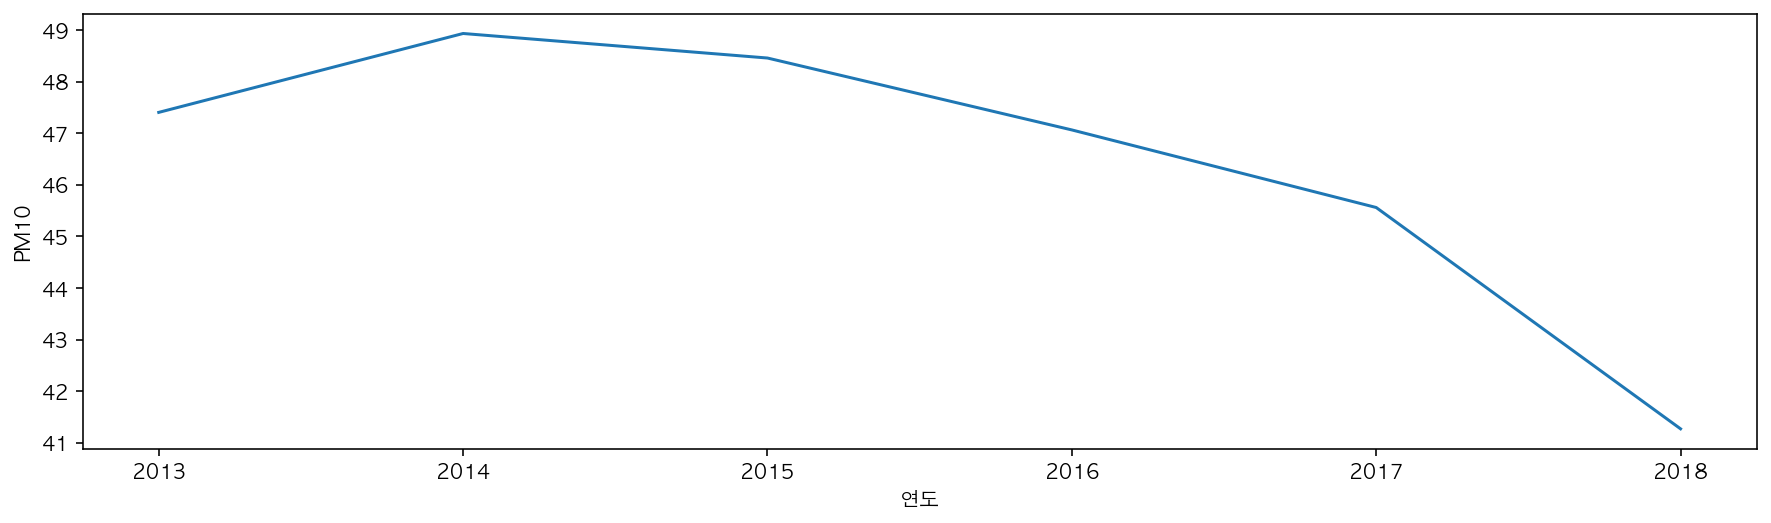

In [131]:
plt.figure(figsize=(15,4))
sns.lineplot(data=df, x='연도', y='PM10', ci=None)


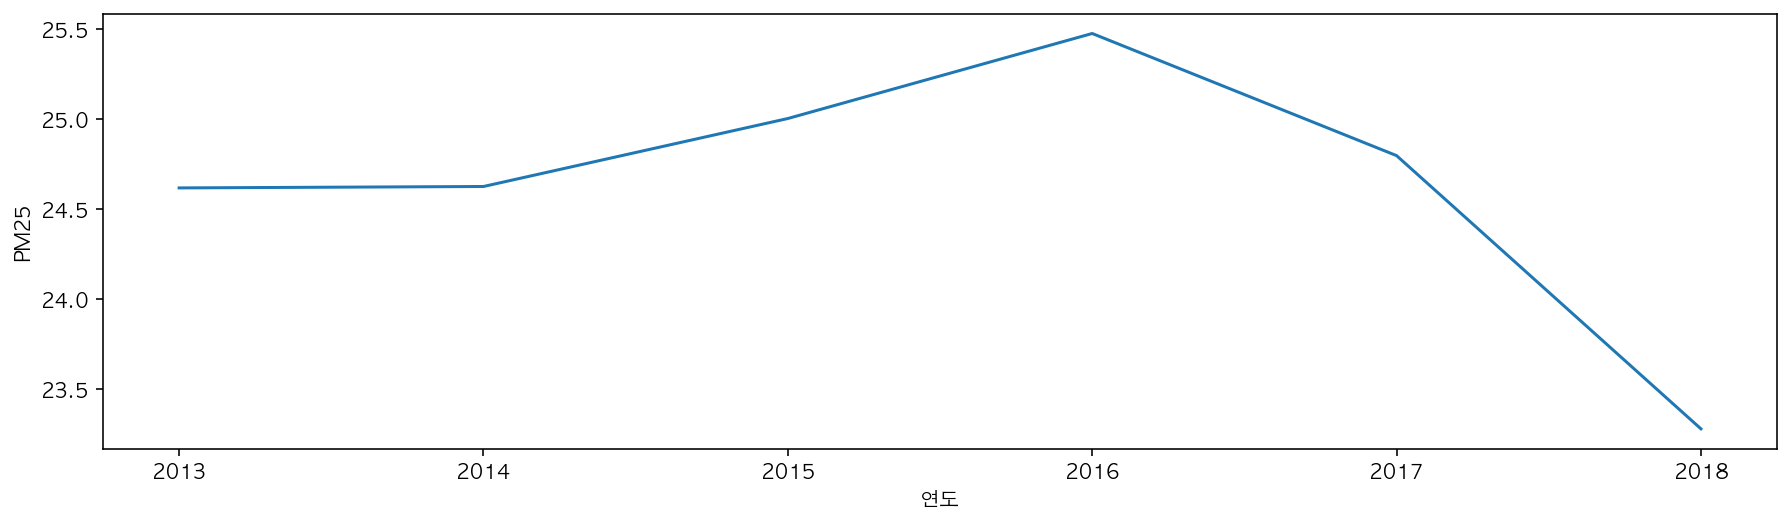

In [132]:
plt.figure(figsize=(15,4))
sns.lineplot(data=df, x='연도', y='PM25', ci=None)

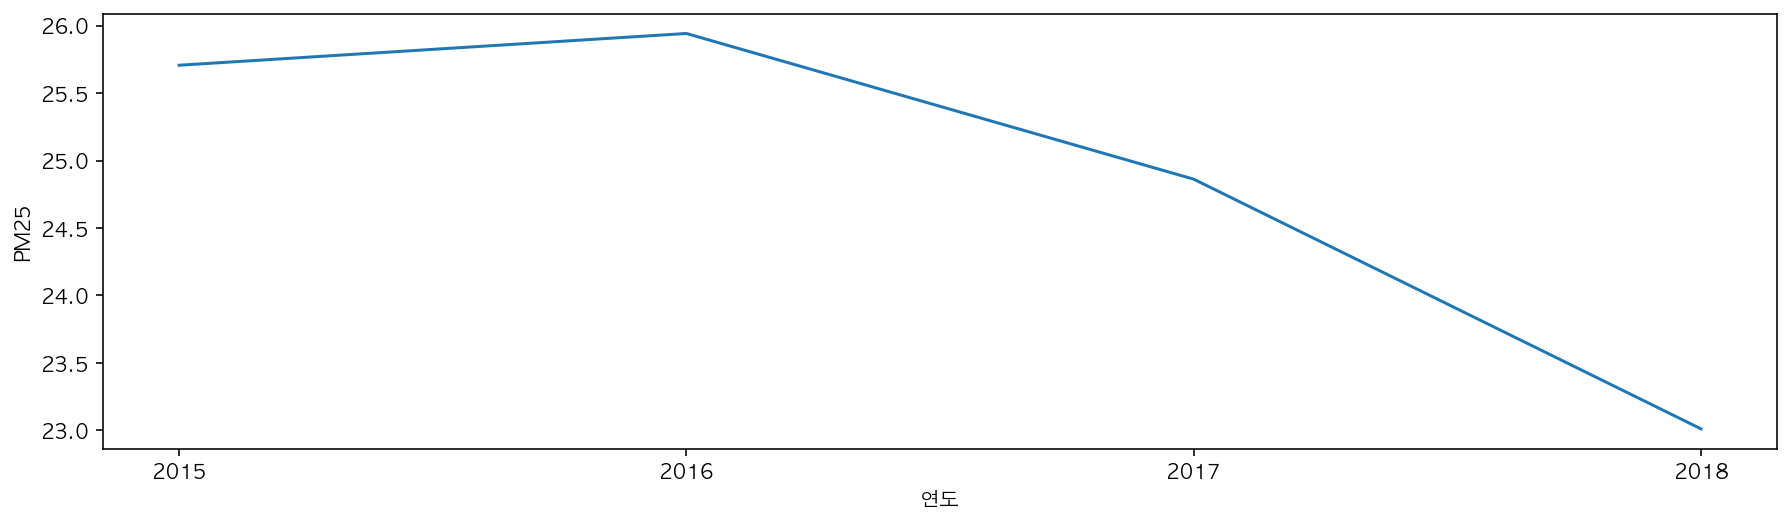

In [68]:
plt.figure(figsize=(15,4))
sns.lineplot(data=df, x='연도', y='PM25', ci=None)

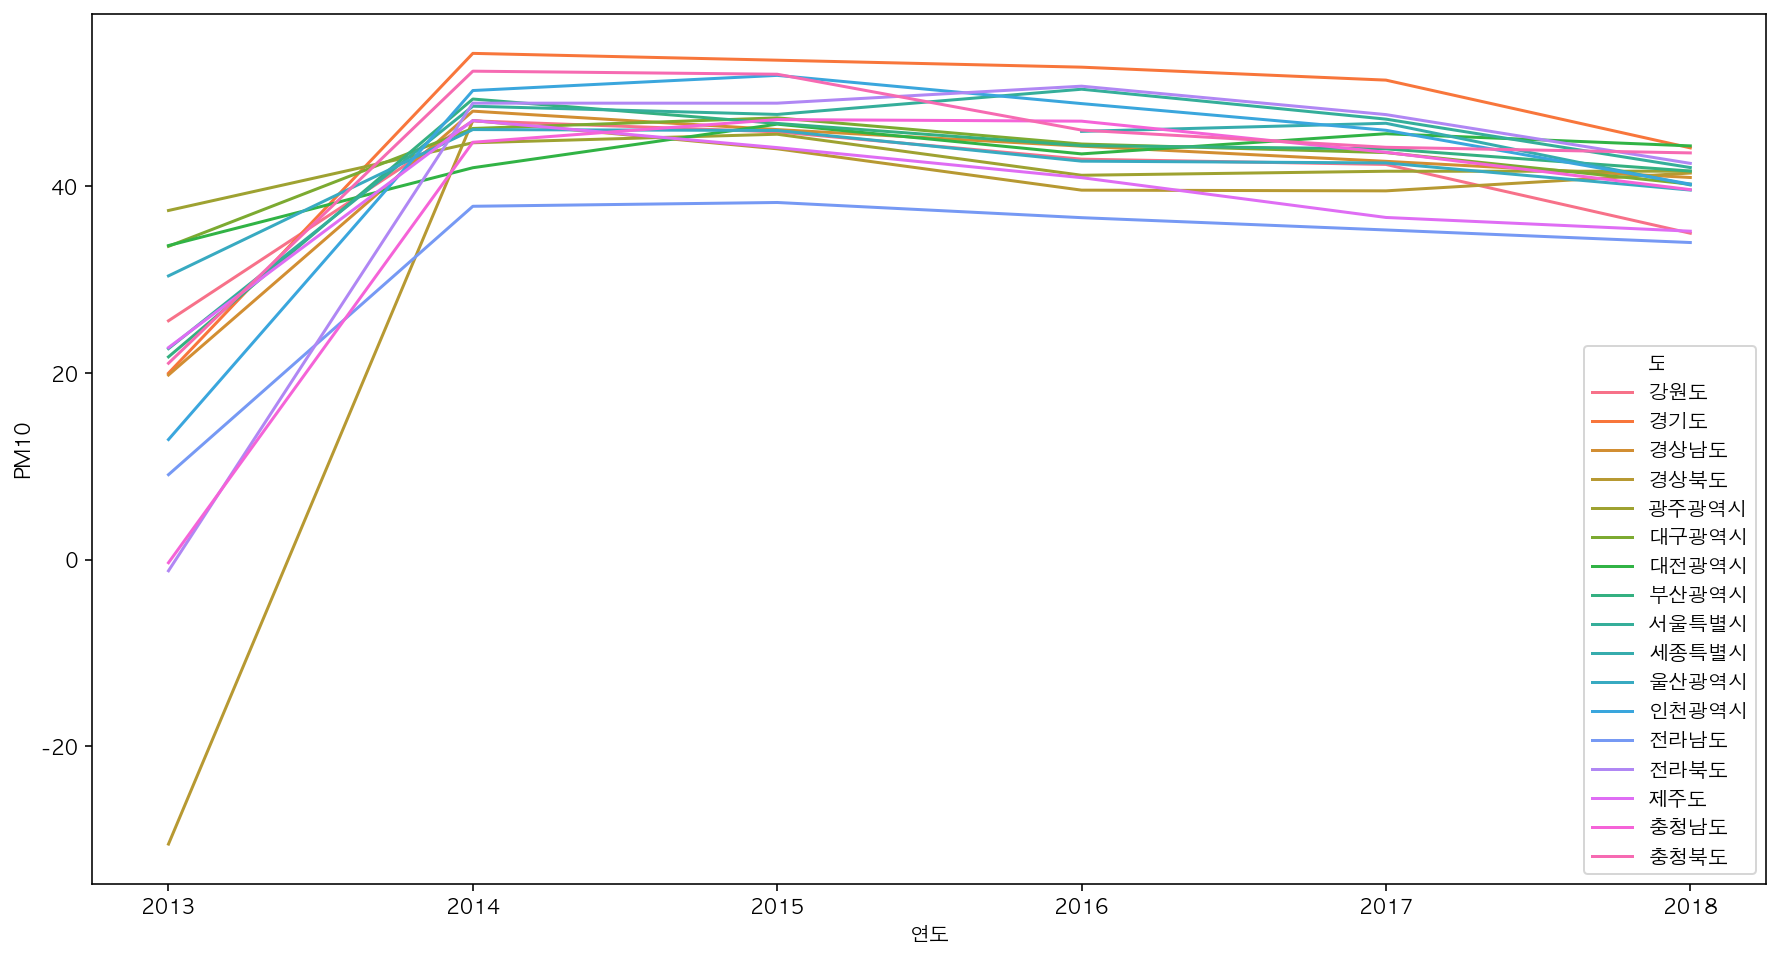

In [69]:
plt.figure(figsize=(15,8))
sns.lineplot(data=df, x='연도', y='PM10', hue='도', ci=None)

In [70]:
df.head()

,도,측정소명,일시,연도,월,일,SO2,CO,O3,NO2,PM10,PM25
0,강원도,중앙로,2013-01-01,2013,01,01,0.007125,1.258333,0.008708,0.028958,35.375000,NaN
1,강원도,중앙로,2013-01-02,2013,01,02,0.004875,0.691667,0.030000,0.007750,18.166667,NaN
2,강원도,중앙로,2013-01-03,2013,01,03,0.006042,0.929167,0.020500,0.015792,30.083333,NaN
3,강원도,중앙로,2013-01-04,2013,01,04,0.007167,1.391667,0.009542,0.033833,50.916667,NaN
4,강원도,중앙로,2013-01-05,2013,01,05,0.006792,1.595833,0.006042,0.037542,62.458333,NaN


### 4) 종관기상관측 전처리

In [71]:
# 일조량 데이터 불러오기
df_s = pd.read_csv('OBS_ASOS_DD_20200304204217.csv', encoding='euc-kr')

# 불러온 일조량 데이터 확인
df_s.head()

,지점,지점명,일시,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),강수 계속시간(hr),10분 최다 강수량(mm),...,0.5m 지중온도(°C),1.0m 지중온도(°C),1.5m 지중온도(°C),3.0m 지중온도(°C),5.0m 지중온도(°C),합계 대형증발량(mm),합계 소형증발량(mm),9-9강수(mm),기사,안개 계속시간(hr)
0,90,속초,2013-01-01,-2.0,-6.7,641.0,2.5,1352.0,0.75,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{눈}1010-1025. {눈}1050-1115. {눈}2355-{눈}{강도0}2400-,NaN
1,90,속초,2013-01-02,-7.0,-9.8,2341.0,-1.3,1.0,1.17,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-{눈}-0110.,NaN
2,90,속초,2013-01-03,-7.6,-11.5,716.0,-3.1,1346.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,90,속초,2013-01-04,-5.2,-10.4,640.0,0.3,1253.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,90,속초,2013-01-05,-1.8,-7.4,124.0,1.9,1430.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
df_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240395 entries, 0 to 240394
Data columns (total 62 columns):
지점                     240395 non-null int64
지점명                    240395 non-null object
일시                     240395 non-null object
평균기온(°C)               240134 non-null float64
최저기온(°C)               240356 non-null float64
최저기온 시각(hhmi)          240364 non-null float64
최고기온(°C)               240361 non-null float64
최고기온 시각(hhmi)          240365 non-null float64
강수 계속시간(hr)            27016 non-null float64
10분 최다 강수량(mm)         54349 non-null float64
10분 최다강수량 시각(hhmi)     39813 non-null float64
1시간 최다강수량(mm)          54357 non-null float64
1시간 최다 강수량 시각(hhmi)    41139 non-null float64
일강수량(mm)               87133 non-null float64
최대 순간 풍속(m/s)          240280 non-null float64
최대 순간 풍속 풍향(16방위)      240282 non-null float64
최대 순간풍속 시각(hhmi)       240286 non-null float64
최대 풍속(m/s)             240269 non-null float64
최대 풍속 풍향(16방위)         240278 non-null float64
최대 풍속 

In [73]:
df_s['합계 일조시간(hr)'].isnull().sum()

383

In [74]:
# 도로 분류하기 위해 '지점명' 확인
df_s['지점명']

0         속초
1         속초
2         속초
3         속초
4         속초
          ..
240390    남해
240391    남해
240392    남해
240393    남해
240394    남해
Name: 지점명, Length: 240395, dtype: object

In [75]:
# 지점명에 붙은 접사 제거
df_s['지점명'] = df_s['지점명'].str.replace('시$','').str.replace('군$','').str.replace(r'\(.*?\)','').str.replace('^북','')

In [76]:
# 도시명의 정식 명칭을 dic 변수에 저장
dic = {'서울':'서울특별시','인천':'인천광역시','부산':'부산광역시',
      '대구':'대구광역시','광주':'광주광역시','대전':'대전광역시',
      '부산':'부산광역시','제주':'제주특별자치도','세종':'세종특별자치시',
      '울산':'울산광역시'}

In [77]:
# '지점명' 컬럼 내 도시명을 정식 명칭으로 변경
df_s['지점명'].replace(dic, inplace=True)

In [78]:
# 일조량 데이터는 광역시,특별시,특별자치시 및 특별자치도의
# 시군구의 데이터가 안나와 있기 때문에 제거를 위한 리스트 dic을 이용해 생성
remove = list(dic.values())

In [79]:
# 도 컬럼을 추가하기 위해 행정구역 현황 데이터 불러오기
df_d = pd.read_csv('행정구역_현황_20200310195900.csv', encoding='euc-kr')

In [80]:
# 사용할 데이터의 범위만 선택
df_d = df_d[2:]

In [81]:
# 소계 row는 사용하지 않기 때문에 제거 
df_l = df_d[~df_d['소재지(시군구)별(2)'].str.contains('소계')]

In [82]:
# 광역시,특별시, 특별자치시 및 특별자치도 데이터 제거
df_l= df_l[~df_l['소재지(시군구)별(1)'].isin(remove)]

In [83]:
# 일조량 데이터의 지점명과 맞추기 위해 시,군 제거
df_l['소재지(시군구)별(2)']= df_l['소재지(시군구)별(2)'].str.replace(r'시$','').str.replace(r'군$','')

In [84]:
# 제거가 잘 되었는지 확인 
df_l['소재지(시군구)별(2)'].unique()

array(['수원', '성남', '고양', '용인', '부천', '안산', '안양', '남양주', '화성', '평택', '의정부',
       '시흥', '파주', '광명', '김포', '군포', '광주', '이천', '양주', '오산', '구리', '안성',
       '포천', '의왕', '하남', '여주', '양평', '동두천', '과천', '가평', '연천', '춘천', '원주',
       '강릉', '동해', '태백', '속초', '삼척', '홍천', '횡성', '영월', '평창', '정선', '철원',
       '화천', '양구', '인제', '고성', '양양', '청주', '충주', '제천', '보은', '옥천', '영동',
       '진천', '괴산', '음성', '단양', '증평', '천안', '공주', '보령', '아산', '서산', '논산',
       '계룡', '당진', '금산', '부여', '서천', '청양', '홍성', '예산', '태안', '전주', '군산',
       '익산', '정읍', '남원', '김제', '완주', '진안', '무주', '장수', '임실', '순창', '고창',
       '부안', '목포', '여수', '순천', '나주', '광양', '담양', '곡성', '구례', '고흥', '보성',
       '화순', '장흥', '강진', '해남', '영암', '무안', '함평', '영광', '장성', '완도', '진도',
       '신안', '포항', '경주', '김천', '안동', '구미', '영주', '영천', '상주', '문경', '경산',
       '군위', '의성', '청송', '영양', '영덕', '청도', '고령', '성주', '칠곡', '예천', '봉화',
       '울진', '울릉', '창원', '진주', '통영', '사천', '김해', '밀양', '거제', '양산', '의령',
       '함안', '창녕', '남해', '하동', '산청', '함양', '거창',

In [85]:
# '도' 리스트 생성
시군구_lst = list(df_l['소재지(시군구)별(1)'].unique())

In [86]:
# 도별 행정구역 리스틀 만들기 위해 도별 번호 부여
[print(i,j) for i,j in enumerate(시군구_lst) ]

0 경기도
1 강원도
2 충청북도
3 충청남도
4 전라북도
5 전라남도
6 경상북도
7 경상남도


[None, None, None, None, None, None, None, None]

In [87]:
# 부여된 번호를 활용하여 각 도별 행정구역 리스트 생성

경기도 = []
강원도 = [] 
충청북도 = []
충청남도 = []
전라북도 = []
전라남도 = []
경상북도 = []
경상남도 = [] 

for i in range(len(시군구_lst)):
    if 시군구_lst[i] == '경기도':
        경기도.append(df_l.loc[df_l['소재지(시군구)별(1)']==시군구_lst[0],'소재지(시군구)별(2)'].to_list())
    elif 시군구_lst[i] == '강원도':
        강원도.append(df_l.loc[df_l['소재지(시군구)별(1)']==시군구_lst[1],'소재지(시군구)별(2)'].to_list())
    elif 시군구_lst[i] == '충청북도':
        충청북도.append(df_l.loc[df_l['소재지(시군구)별(1)']==시군구_lst[2],'소재지(시군구)별(2)'].to_list())
    elif 시군구_lst[i] == '충청남도':
        충청남도.append(df_l.loc[df_l['소재지(시군구)별(1)']==시군구_lst[3],'소재지(시군구)별(2)'].to_list())
    elif 시군구_lst[i] == '전라북도':
        전라북도.append(df_l.loc[df_l['소재지(시군구)별(1)']==시군구_lst[4],'소재지(시군구)별(2)'].to_list())
    elif 시군구_lst[i] == '전라남도':
        전라남도.append(df_l.loc[df_l['소재지(시군구)별(1)']==시군구_lst[5],'소재지(시군구)별(2)'].to_list())
    elif 시군구_lst[i] == '경상북도':
        경상북도.append( df_l.loc[df_l['소재지(시군구)별(1)']==시군구_lst[6],'소재지(시군구)별(2)'].to_list())
    elif 시군구_lst[i] == '경상남도':
        경상남도.append(df_l.loc[df_l['소재지(시군구)별(1)']==시군구_lst[7],'소재지(시군구)별(2)'].to_list())

In [88]:
# 밑의 코드를 돌려본 결과 행정구역이 명확하지 않은 행정구역들 null 처리되어 행정구역 추가
강원도.append('대관령')
경상북도.append('울릉도')
경상북도.append('추풍령')
전라남도.append('흑산도')
전라북도.append('고산')
제주도 = ['서귀포','성산']
인천광역시 = ['백령도','강화']

In [89]:
# isin을 활용하여 지점명이 리스트에 있을 경우 그 리스트 이름을 '도' 컬럼에 할당
df_s.loc[df_s['지점명'].isin(경기도[0]),'도'] = '경기도'
df_s.loc[df_s['지점명'].isin(강원도[0]),'도'] = '강원도'
df_s.loc[df_s['지점명'].isin(충청북도[0]),'도'] = '충청북도'
df_s.loc[df_s['지점명'].isin(충청남도[0]),'도'] = '충청남도'
df_s.loc[df_s['지점명'].isin(전라북도[0]),'도'] = '전라북도'
df_s.loc[df_s['지점명'].isin(전라남도[0]),'도'] = '전라남도'
df_s.loc[df_s['지점명'].isin(경상북도[0]),'도'] = '경상북도'
df_s.loc[df_s['지점명'].isin(경상남도[0]),'도'] = '경상남도'
df_s.loc[df_s['지점명'].isin(제주도),'도'] = '제주특별자치도'
df_s.loc[df_s['지점명'].isin(인천광역시),'도'] = '인천광역시'

In [90]:
# 특별시, 광역시, 특별자치도는 지점명의 값을 '도' 컬럼 값에 할당
df_s['도'] = df_s['도'].fillna(df_s['지점명'])

In [91]:
# 2019년 데이터 제외
df_s = df_s[~df_s['일시'].str.contains('2019')]

In [92]:
# 사용할 컬럼만 가져오기
df_use = df_s[['도', '지점명', '일시','합계 일조시간(hr)']].copy()

In [93]:
# 결측값을 0으로 채우기
df_use['합계 일조시간(hr)'] = df_use['합계 일조시간(hr)'].fillna(0)

In [94]:
# merge함수를 사용하기 위해 일시를 연도와 날짜 컬럼으로 나누기
df_use['연도'] = df_use['일시'].str.split('-').str.get(0)
df_use['월'] = df_use['일시'].str.split('-').str.get(1)
df_use['일'] = df_use['일시'].str.split('-').str.get(2) 

In [95]:
# 컬럼 순서 변경
df_use = df_use[['연도', '월', '일', '도', '지점명', '합계 일조시간(hr)', '일시']]

# 확인
df_use.head()

,연도,월,일,도,지점명,합계 일조시간(hr),일시
0,2013,01,01,강원도,속초,5.4,2013-01-01
1,2013,01,02,강원도,속초,9.0,2013-01-02
2,2013,01,03,강원도,속초,8.9,2013-01-03
3,2013,01,04,강원도,속초,9.0,2013-01-04
4,2013,01,05,강원도,속초,8.8,2013-01-05


In [96]:
df_use.shape

(205867, 7)

#### 연도별 지역별 일조량 그래프

<Figure size 1440x288 with 0 Axes>

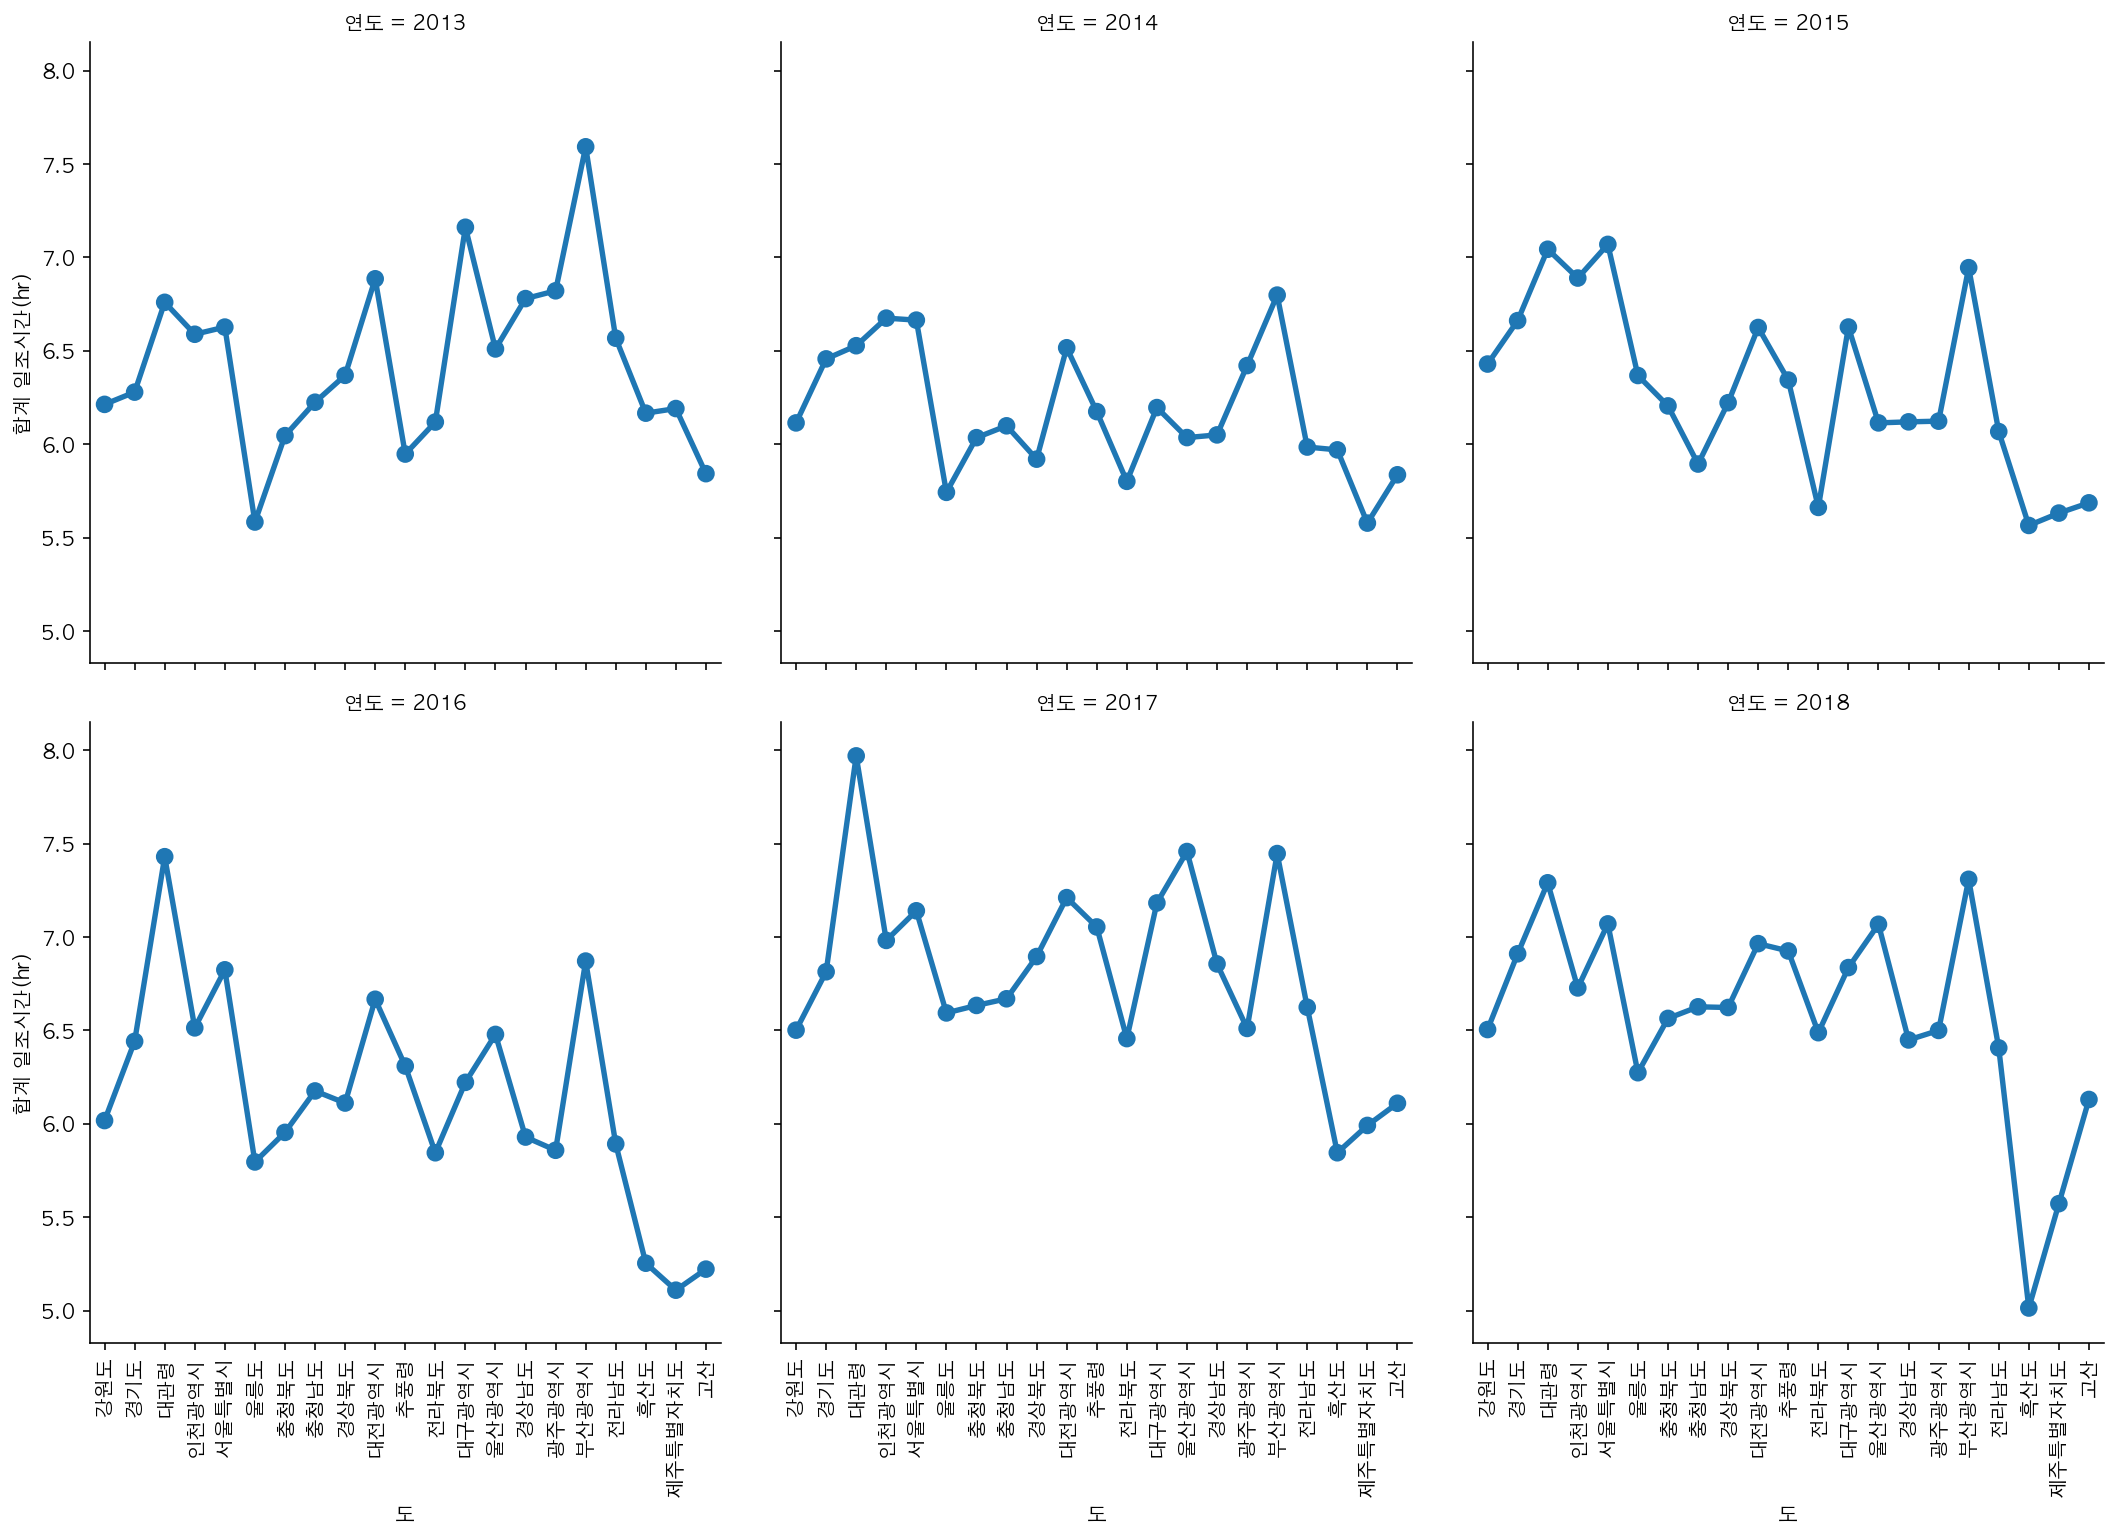

In [97]:
plt.figure(figsize=(20,4))
g = sns.catplot(data=df_use,x='도',y='합계 일조시간(hr)',col='연도',col_wrap=3,kind='point',ci=None)
g.set_xticklabels(rotation=90)

plt.savefig('연도별_지역별_일조량.png', dpi=300)

#### 연도별 일조시간 그래프

 - 2017년이 일조량이 가장 많았고 2016년이 가장 일조시간이 적음
 - 2017년에 강수가 적어 일조량이 많음

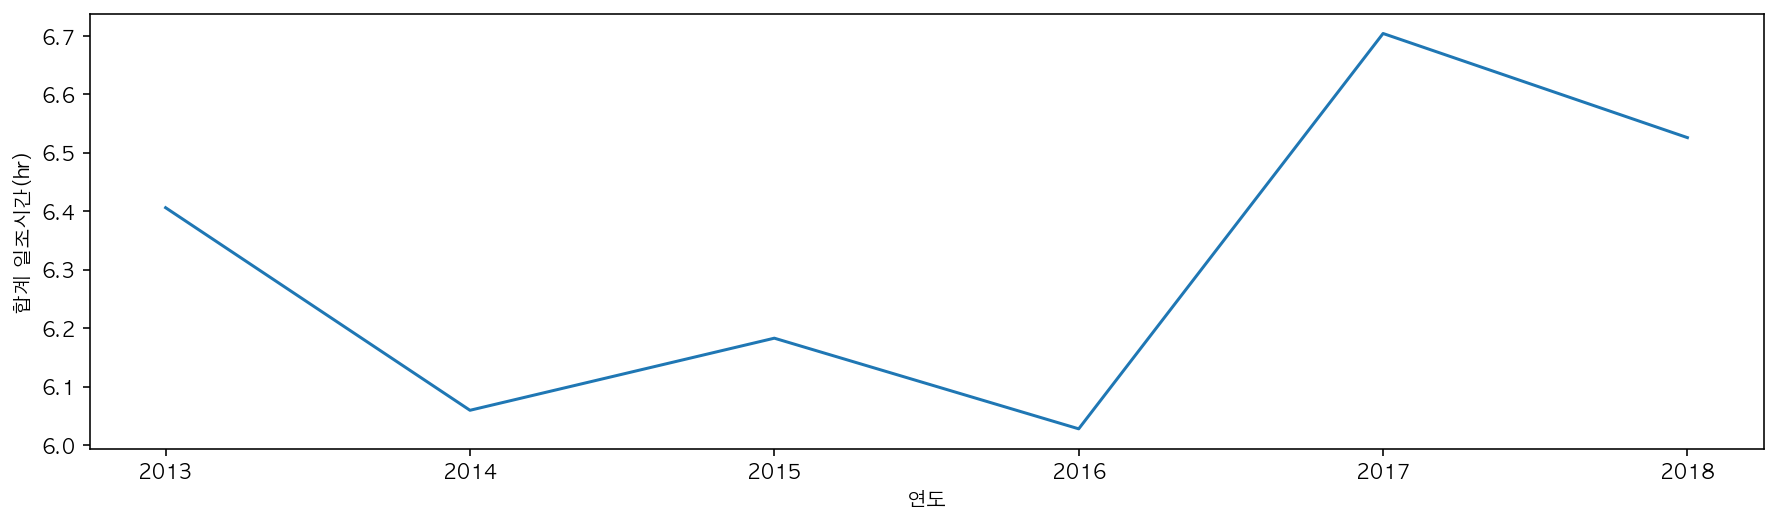

In [98]:
plt.figure(figsize=(15,4))
sns.lineplot(data=df_use, x='연도', y='합계 일조시간(hr)', ci=None)

plt.savefig('연도별_일조량.png', dpi=300)

#### 월별 일조시간 그래프

 - 5월이 일조시간이 가장 많았으며, 7월은 일조시간이 가장 적음
 - 7월에 강수량이 집중되어 일조시간이 적음

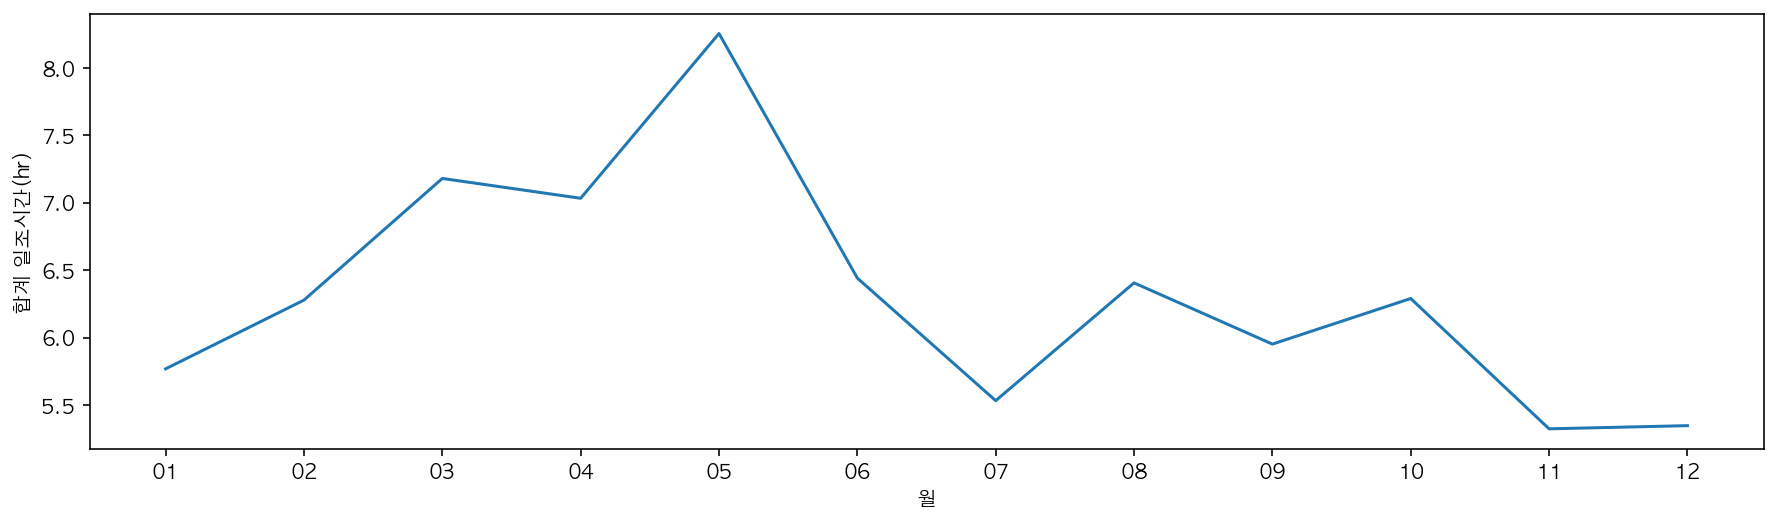

In [99]:
plt.figure(figsize=(15,4))
sns.lineplot(data=df_use, x='월', y='합계 일조시간(hr)', ci=None)

plt.savefig('월별_일조량.png', dpi=300)

## 4. 머신러닝 모델 적용

### 1) 토마토 가격과 미세먼지, 일조량 데이터 합치기

In [238]:
# 일조량과 미세먼지 합치기
tt1 = pd.merge(tomp, df, how='right', on=['일시', '연도', '월', '일', '도'])
tt1.isnull().sum()

품종명     721271
도            0
마켓명     721271
연도           0
날짜      721271
가격      721271
월            0
일            0
연월      721271
일시           0
측정소명         0
SO2      21544
CO       22659
O3       20802
NO2      15327
PM10     25698
PM25         0
dtype: int64

In [239]:
tt1

,품종명,도,마켓명,연도,날짜,가격,월,일,연월,일시,측정소명,SO2,CO,O3,NO2,PM10,PM25
0,NaN,강원도,NaN,2013,NaN,NaN,01,01,NaN,2013-01-01,중앙로,0.007125,1.258333,0.008708,0.028958,35.375000,31.543635
1,NaN,강원도,NaN,2013,NaN,NaN,01,01,NaN,2013-01-01,석사동,0.006875,1.104167,0.010667,0.030083,60.333333,31.543635
2,NaN,강원도,NaN,2013,NaN,NaN,01,01,NaN,2013-01-01,방산면,0.002288,0.400000,0.027417,0.004958,29.250000,31.543635
3,NaN,강원도,NaN,2013,NaN,NaN,01,01,NaN,2013-01-01,중앙동(원주),0.014833,1.500000,0.008750,0.038250,68.500000,31.543635
4,NaN,강원도,NaN,2013,NaN,NaN,01,01,NaN,2013-01-01,명륜동,0.011667,1.183333,0.011708,0.034667,74.291667,31.543635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721266,NaN,충청북도,NaN,2018,NaN,NaN,12,31,NaN,2018-12-31,복대동,0.004875,0.512500,0.005542,0.042917,79.833333,48.333333
721267,NaN,충청북도,NaN,2018,NaN,NaN,12,31,NaN,2018-12-31,호암동,0.003125,0.733333,0.007625,0.033833,62.000000,30.125000
721268,NaN,충청북도,NaN,2018,NaN,NaN,12,31,NaN,2018-12-31,칠금동,0.005542,0.779167,0.005208,0.034417,63.958333,37.375000
721269,NaN,충청북도,NaN,2018,NaN,NaN,12,31,NaN,2018-12-31,장락동,0.008125,0.558333,0.006292,0.032708,55.958333,27.666667


In [240]:
tt1['품종명'] = '토마토(10kg)'
tt1['품종명']

0         토마토(10kg)
1         토마토(10kg)
2         토마토(10kg)
3         토마토(10kg)
4         토마토(10kg)
            ...    
721266    토마토(10kg)
721267    토마토(10kg)
721268    토마토(10kg)
721269    토마토(10kg)
721270    토마토(10kg)
Name: 품종명, Length: 721271, dtype: object

In [134]:
# 일조시간 합치기
tt = pd.merge(tt1, df_use, on=['일시', '연도', '월', '일'])

# 확인
tt

,품종명,도_x,마켓명,날짜,가격,연월,도_y,측정소명,SO2,CO,...,NO2,PM10,PM25,연도,월,일,도,지점명,합계 일조시간(hr),일시


In [107]:
tt.to_csv('merge.csv', index=False)

### 2) Voting Classifiers(다수결 분류)

#### XGBoost

#### Random forest

#### LightGBM